In [1]:
from typing import List, TypedDict
import time

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
docs = (
    PyPDFLoader("./documents/book1.pdf").load() +
    PyPDFLoader("./documents/book2.pdf").load() +
    PyPDFLoader("./documents/book3.pdf").load()
)

In [3]:
len(docs)

2123

In [4]:
# 2) Chunk
chunks = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=150).split_documents(docs)

# 3) Clean text to avoid UnicodeEncodeError (surrogates from PDF extraction)
for d in chunks:
    d.page_content = d.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")

In [5]:
len(chunks)

6396

In [6]:
# 3) Index (fresh collection each run)
embeddings = OpenAIEmbeddings(model='text-embedding-3-large')
vector_store = FAISS.from_documents(chunks, embeddings)

In [7]:
retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})

In [8]:
# 4) LLM + prompt
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [9]:
class State(TypedDict):
    question: str
    docs: List[Document]
    answer: str

In [ ]:
def retrieve(state):
    q = state["question"]
    return {"docs": retriever.invoke(q)}

In [ ]:

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Answer only from the context. If not in context, say you don't know."),
        ("human", "Question: {question}\n\nContext:\n{context}"),
    ]
)
def generate(state):
    context = "\n\n".join(d.page_content for d in state["docs"])
    out = (prompt | llm).invoke({"question": state["question"], "context": context})
    return {"answer": out.content}


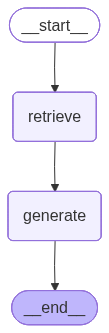

In [25]:
g = StateGraph(State)
g.add_node("retrieve", retrieve)
g.add_node("generate", generate)
g.add_edge(START, "retrieve")
g.add_edge("retrieve", "generate")
g.add_edge("generate", END)
app = g.compile()

app

In [33]:
# 5) Run
res = app.invoke({"question": "WHat is a transformer in deep learning.", "docs": [], "answer": ""})
print(res["answer"])

A transformer in deep learning is a type of model architecture that is particularly effective for processing sequential data, such as text. It utilizes mechanisms called self-attention and feedforward neural networks to weigh the importance of different parts of the input data, allowing it to capture long-range dependencies and relationships within the data. Unlike traditional recurrent neural networks (RNNs), transformers do not process data sequentially, which enables them to be more parallelizable and efficient in training. This architecture has become foundational in natural language processing tasks and has led to significant advancements in the field.


In [34]:
print(res['docs'][0].page_content)
print('*'*100)
print(res['docs'][1].page_content)
print('*'*100)
print(res['docs'][2].page_content)
print('*'*100)
print(res['docs'][3].page_content)

ducingrepresentationsthatareexpressedintermsofother,simplerrepresentations.
Deeplearningallowsthecomputertobuildcomplexconceptsoutofsimplercon-
cepts.Figureshowshowadeeplearningsystemcanrepresenttheconceptof1.2
animageofapersonbycombiningsimplerconcepts,suchascornersandcontours,
whichareinturndeﬁnedintermsofedges.
Thequintessentialexampleofadeeplearningmodelisthefeedforwarddeep
networkormultilayerperceptron(MLP).Amultilayerperceptronisjusta
mathematicalfunctionmappingsomesetofinputvaluestooutputvalues.The
functionisformedbycomposingmanysimplerfunctions.Wecanthinkofeach
applicationofadiﬀerentmathematicalfunctionasprovidinganewrepresentation
oftheinput.
Theideaoflearningtherightrepresentationforthedataprovidesoneperspec-
tiveondeeplearning.Anotherperspectiveondeeplearningisthatdepthallowsthe
computertolearnamulti-stepcomputerprogram.Eachlayeroftherepresentation
****************************************************************************************************
6 A convolution is a mathem